# Sleep Apena

In [1]:
import os                           
import numpy as np                   
import pandas as pd                 
import matplotlib.pyplot as plt      
import cv2                           
from tqdm import tqdm
import time

# 資料集載入、再觀察與處理

In [2]:
train_csv = pd.read_csv("sleep_data_v2/train.csv", index_col=False)
test_csv = pd.read_csv("sleep_data_v2/test.csv", index_col=False)

train_data=[]
test_data=[]
train_labels=[]
test_labels=[]

sleep_type = {0:"Normal", 1:"Sick"}

In [3]:
def get_train(spec_type, aug_type):
    train_path = "./sleep_data_v2/Training_Data/"+spec_type+"_Train_" + aug_type # 指定訓練集的讀檔路徑
    global train_data
    for eachfile in train_csv["Number"]:                              # 用 for 迴圈將檔案名稱一個個唱名
        image = cv2.imread(os.path.join(train_path, eachfile+".png"))  # 被唱到名的檔案就會和訓練集路徑用 os.path.join 結合
                                                                       # 用 cv2.imread 將檔案開啟
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                 # 由於 cv2 開檔讀進來的是 BGR 所以我們將其轉成 RGB
        train_data.append(image)                                       # 將開啟的檔案放到 train_data 中
        
        
def get_test(spec_type, aug_type):
    test_path = "./sleep_data_v2/Training_Data/"+spec_type+"_Test_"+aug_type
    global test_data
    for eachfile in test_csv["Number"]:
        image = cv2.imread(os.path.join(test_path, eachfile+".png"))    
        #print(eachfile)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        test_data.append(image)
        
        
spec_type = 'Mel'
aug_type = ['None']
for x in aug_type:
    get_train(spec_type, x)
    get_test(spec_type, x)
    train_labels = np.concatenate((train_labels, train_csv['Label'].values), axis=None).astype(np.int8)
    test_labels = np.concatenate((test_labels, test_csv['Label'].values), axis=None).astype(np.int8)
print(f'Training samples: {len(train_data)}')
print(f'Testing samples: {len(test_data)}')
print(f'Training labels: {len(train_labels)}')
print(f'Testing labels: {len(test_labels)}')

Training samples: 134
Testing samples: 20
Training labels: 134
Testing labels: 20


In [4]:
# plt.figure(figsize=(25,30))                                        # 避免圖畫太小，用 figsize 來調控一下大小
# for i in range(10):
#     ax = plt.subplot(6, 5, i+1)                                    # 依序呼叫每個畫圖位置 
#     plt.title("class : "+str(train_labels[i] )+", "+str(sleep_type[train_labels[i]]), 
#                fontsize=18)                                        # 宣告每張圖的 title，此處放入對應類別
#     plt.xticks([])                                                 # 避免出現不必要邊框，所以宣告 x 軸上不用貼刻度
#     plt.yticks([])
#     ax.set_xlabel(train_data[i].shape,fontsize=18) 
#     ax.imshow(train_data[i])                                       # 將指定的影像放入呼叫的畫圖位置

In [5]:
from utils.image_processing_v2 import my_processing
# my_processing(
#                  dataset,     # 放入開完檔案的影像進此函述做前處理 
#                  outsize,     # output 時的 image size
#                  pre_type     # 希望做什麼樣的特徵強化，共有["ori", "his", "cla", "gau"]四種可以填入
#                  )

pre_train = my_processing(dataset = train_data, outsize=456, pre_type="his")
pre_test  = my_processing(dataset = test_data, outsize=456, pre_type="his")

# outsize 設定 456 是為了放入底下模型所指定的 size
print(train_data[0].shape)
print(pre_train[0].shape)
del train_data
del test_data

100%|██████████| 20/20 [00:00<00:00, 337.05it/s]

(480, 640, 3)
(456, 456, 3)


In [6]:
# plt.figure(figsize=(25,30))                                        # 避免圖畫太小，用 figsize 來調控一下大小
# for i in range(10):
#     ax = plt.subplot(6, 5, i+1)                                    # 依序呼叫每個畫圖位置
#     plt.title("class : "+str(train_labels[i] )+", "+str(sleep_type[train_labels[i]]), 
#                fontsize=18)                                        # 宣告每張圖的 title，此處放入對應類別
#     plt.xticks([])                                                 # 避免出現不必要邊框，所以宣告 x 軸上不用貼刻度
#     plt.yticks([])
#     ax.set_xlabel(pre_train[i].shape, fontsize=18)
#     ax.imshow(pre_train[i])                                       # 將指定的影像放入呼叫的畫圖位置

In [7]:
### Train_Test_Split

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split( pre_train, 
                                                       train_labels,
                                                       test_size=0.1, 
                                                       random_state=10,
                                                       stratify= train_labels)
del pre_train
del train_labels

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import (Input, Dense, GlobalAveragePooling2D)
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Imbalance Data

In [9]:
from sklearn.utils import class_weight
classweight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
classweights = { 0: classweight[0], 1: classweight[1] }
classweights

{0: 3.5294117647058822, 1: 0.5825242718446602}

對類別取一個比例，依照比例去增加其對應的資料之資料量，一般我們直接以複製資料做為增加的方式 (此例中我們選此法)<br>
![Imgur](https://i.imgur.com/LbxlfS3.jpg?1)

In [10]:
# X_train_prod = X_train.copy()
# Y_train_prod = Y_train.copy()

# # 不同 label 補不同倍數的值
# task = {0:9,1:2}
# for i in range(2):
#     tmp_x = X_train[Y_train==task[i]].copy()
#     tmp_y = Y_train[Y_train==task[i]].copy()
#     for j in range(task[i]):
#         X_train_prod = np.concatenate([X_train_prod, tmp_x])
#         Y_train_prod = np.concatenate([Y_train_prod, tmp_y])

In [11]:
# print(X_train_prod.shape)
# print(Y_train_prod.shape)

### Data Augmentation  資料增強

In [12]:
datagen = ImageDataGenerator(
                                width_shift_range = 0.0,     # 水平平移
                                height_shift_range = 0.0,    # 垂直平移
                                rotation_range = 0,        # 0-180 任一角度旋轉
                                horizontal_flip = True,      # 任意水平翻轉
                                vertical_flip = True,        # 任意垂直翻轉
                                fill_mode = "constant",      # 在旋轉或平移時，有空隙發生，則空隙補常數
                                cval = 0                     # 設定常數值為 0
                             )

In [13]:
def load_base_model():
    global X_train
    global X_valid
    global pre_test
    base_model = int(input("""Choose a base model
1. EfficientNetB5
2. DenseNet201
3. InceptionV3
4. ResNet50
5. VGG16
"""))
    
    if base_model==1:
        #from efficientnet import EfficientNetB5, preprocess_input
        #from efficientnet.keras import EfficientNetB5, preprocess_input
        from keras_efficientnets import EfficientNetB5, preprocess_input
        return EfficientNetB5(weights='imagenet',include_top=False)
    
    elif base_model==2:
        from keras.applications.densenet import DenseNet201, preprocess_input
        return DenseNet201(weights='imagenet',include_top=False)
    
    elif base_model==3:
        from keras.applications.inception_v3 import InceptionV3, preprocess_input
        return InceptionV3(weights='imagenet',include_top=False)
        
    elif base_model==4:
        from keras.applications import ResNet50
        from keras.applications.resnet50 import preprocess_input
        return ResNet50(weights='imagenet',include_top=False)
    
    elif base_model==5:
        from keras.applications import VGG16
        from keras.applications.vgg16 import preprocess_input
        return VGG16(weights='imagenet',include_top=False)
    else:
        raise ValueError("Wrong value")
        
    X_train = np.array([preprocess_input(image) for image in X_train])
    X_valid = np.array([preprocess_input(image) for image in X_valid])
    pre_test = np.array([preprocess_input(image) for image in pre_test])

In [14]:
base_model = load_base_model()
pool = GlobalAveragePooling2D()(base_model.output) 
output = Dense(2, activation='softmax')(pool)
model = Model(inputs = base_model.input, outputs = output)


base_model.trainable = False
learning_rate = 1e-4
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

Choose a base model
1. EfficientNetB5
2. DenseNet201
3. InceptionV3
4. ResNet50
5. VGG16
1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
#from keras.utils import plot_model
#plot_model(base_model, to_file='./outputs/EfficientNetB5_model.png')    # 畫畫模型圖

### 開始訓練

In [16]:
batch_sizes = 2
num_epoch=15
step_size_train = len(X_train)//batch_sizes

start_time = time.perf_counter()
model_history = model.fit_generator(
                                    datagen.flow(X_train, np.eye(2)[Y_train], batch_size=batch_sizes),
                                    steps_per_epoch = step_size_train,
                                    validation_data = (X_valid, np.eye(2)[Y_valid]),
                                    class_weight = classweights,
                                    epochs=num_epoch, verbose=1,
                                    )
end_time = time.perf_counter()
print(f'Time passed: {end_time-start_time} seconds')

Epoch 1/15
60/60 [==============================] - 183s 3s/step - loss: 0.7515 - accuracy: 0.6250 - val_loss: 0.8150 - val_accuracy: 0.2143
Epoch 2/15
60/60 [==============================] - 153s 3s/step - loss: 0.6303 - accuracy: 0.6000 - val_loss: 0.7038 - val_accuracy: 0.3571
Epoch 3/15
60/60 [==============================] - 152s 3s/step - loss: 0.4650 - accuracy: 0.7417 - val_loss: 0.6000 - val_accuracy: 0.7143
Epoch 4/15
60/60 [==============================] - 152s 3s/step - loss: 0.6116 - accuracy: 0.7333 - val_loss: 0.6156 - val_accuracy: 0.5714
Epoch 5/15
60/60 [==============================] - 151s 3s/step - loss: 0.4205 - accuracy: 0.7583 - val_loss: 0.7339 - val_accuracy: 0.5000
Epoch 6/15
60/60 [==============================] - 151s 3s/step - loss: 0.3830 - accuracy: 0.8083 - val_loss: 0.5508 - val_accuracy: 0.7857
Epoch 7/15
60/60 [==============================] - 151s 3s/step - loss: 0.4358 - accuracy: 0.7250 - val_loss: 0.8790 - val_accuracy: 0.4286
Epoch 8/15
60

### 繪出訓練結果

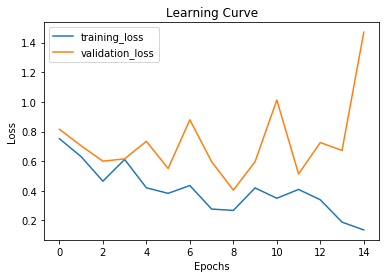

In [17]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [18]:
#model.save("./saved_models/EfficientNetB5_model.h5")

# 用測試集評估成效

In [19]:
results = model.evaluate(pre_test, np.eye(2)[test_labels])
print(f'test loss, test acc: {results}')
print()

pred = model.predict(pre_test)
print(pred)
print()

pred = pred.argmax(-1)
print(pred)
print(test_labels)

20/20 [==============================] - 6s 293ms/step
test loss, test acc: [0.35544484853744507, 0.8500000238418579]

[[9.9943739e-01 5.6259136e-04]
 [4.0944859e-02 9.5905513e-01]
 [1.2161048e-02 9.8783898e-01]
 [9.9884295e-01 1.1570089e-03]
 [5.7238989e-02 9.4276100e-01]
 [7.2675103e-01 2.7324897e-01]
 [6.4664893e-02 9.3533510e-01]
 [4.6175659e-02 9.5382440e-01]
 [9.9348193e-01 6.5179924e-03]
 [8.8052475e-01 1.1947527e-01]
 [9.0322047e-01 9.6779525e-02]
 [2.3530534e-02 9.7646946e-01]
 [9.4504431e-03 9.9054962e-01]
 [4.1037414e-02 9.5896262e-01]
 [1.9096372e-01 8.0903625e-01]
 [1.3382117e-02 9.8661786e-01]
 [2.5582159e-01 7.4417841e-01]
 [3.0938944e-01 6.9061053e-01]
 [9.7305262e-01 2.6947346e-02]
 [1.1540274e-01 8.8459724e-01]]

[0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1]
[0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1]


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
print(f'Accuracy Score: {accuracy_score(test_labels, pred)}')                          
print(f'Confusion Matrix: ')
print(confusion_matrix(test_labels, pred))
print(f'Cohen Kappa Score: {cohen_kappa_score(test_labels, pred)}')

Accuracy Score: 0.85
Confusion Matrix: 
[[ 4  0]
 [ 3 13]]
Cohen Kappa Score: 0.6341463414634145


In [21]:
# test_csv.loc[:,"Label"] = pred
# test_csv.to_csv("./outputs/sleep_apnea_EfficientNetB5_predict_20220819.csv", index=False)